In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [2]:
!git clone https://github.com/beichenzbc/Long-CLIP.git
%cd Long-CLIP

Cloning into 'Long-CLIP'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 269 (delta 40), reused 31 (delta 31), pack-reused 219 (from 1)
Receiving objects: 100% (269/269), 10.25 MiB | 6.45 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/Long-CLIP


In [3]:
%pip install -qqq ftfy regex
%pip install -qqq faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 69.3 MB/s eta 0:00:00


In [4]:
import os
import sys
import csv
import json
import faiss
import time
import math
import glob
import numpy as np
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from PIL import Image

In [5]:
from model import longclip

class LongCLIPEncoder:
    def __init__(self, checkpoint_path: str, device: Optional[str] = None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model, self.preprocess = longclip.load(checkpoint_path, device=self.device)
        self.model.eval()

        # Lấy dimension từ model
        with torch.no_grad():
            tok = longclip.tokenize("probe").to(self.device)
            self.dim = self.model.encode_text(tok).shape[1]

    @torch.no_grad()
    def encode_images(self, image_paths: List[str], batch_size: int = 128) -> torch.Tensor:
        feats = []
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            imgs = [self.preprocess(Image.open(p).convert("RGB")) for p in batch_paths]
            batch = torch.stack(imgs, 0).to(self.device)
            f = self.model.encode_image(batch).float()
            f = f / f.norm(dim=-1, keepdim=True)  # cosine với IP
            feats.append(f.cpu())
        return torch.cat(feats, dim=0)  # (N,512)

    @torch.no_grad()
    def encode_text(self, text: str) -> torch.Tensor:
        tokens = longclip.tokenize([text]).to(self.device)
        feat = self.model.encode_text(tokens).float()
        return (feat / feat.norm(dim=-1, keepdim=True)).cpu() # (1, dim)

# ENCODE IMAGES

In [9]:
KEYFRAME_ROOT = "/content/drive/Shareddrives/keyframe_btc"
CKPT          = "/content/Long-CLIP/checkpoints/longclip-B.pt"
OUT_DIR       = "/content/drive/Shareddrives/data/features-longclip/features"

FOLDERS = []
for folder in sorted(os.listdir(KEYFRAME_ROOT)):
    FOLDERS.append(folder)

SELECTED_FOLDERS = FOLDERS[5:6]
print(SELECTED_FOLDERS, "\n")

encoder = LongCLIPEncoder(CKPT)

for folder in tqdm(sorted(SELECTED_FOLDERS)):
    print(f"Processing {folder} ...")
    folder_path = os.path.join(KEYFRAME_ROOT, folder, "keyframes")
    for video in tqdm(sorted(os.listdir(folder_path))):
        video_path = os.path.join(folder_path, video)
        frame_paths = sorted(glob.glob(os.path.join(video_path, "*.jpg")))
        feats = encoder.encode_images(frame_paths, batch_size=16).numpy().astype(np.float32)
        feats = feats / np.linalg.norm(feats, axis=1, keepdims=True)
        output_folder = Path(OUT_DIR, folder)
        if not output_folder.exists():
            output_folder.mkdir(parents=True)
        output_path = Path(output_folder) / f"{video}.npy"
        np.save(output_path, feats)
        print(f"[SAVE] {output_path} shape={feats.shape}")

print("DONE")


['Keyframes_L26'] 



  0%|          | 0/1 [00:00<?, ?it/s]

Processing Keyframes_L26 ...



  0%|          | 1/397 [00:12<1:20:34, 12.21s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V001.npy shape=(125, 512)



  1%|          | 2/397 [00:23<1:15:58, 11.54s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V002.npy shape=(122, 512)



  1%|          | 3/397 [00:37<1:24:32, 12.88s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V003.npy shape=(122, 512)



  1%|          | 4/397 [00:56<1:38:45, 15.08s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V004.npy shape=(123, 512)



  1%|▏         | 5/397 [01:09<1:34:31, 14.47s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V005.npy shape=(129, 512)



  2%|▏         | 6/397 [01:25<1:38:12, 15.07s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V006.npy shape=(120, 512)



  2%|▏         | 7/397 [01:46<1:49:53, 16.91s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V007.npy shape=(130, 512)



  2%|▏         | 8/397 [02:12<2:07:37, 19.68s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V008.npy shape=(141, 512)



  2%|▏         | 9/397 [02:31<2:06:44, 19.60s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V009.npy shape=(132, 512)



  3%|▎         | 10/397 [02:41<1:47:47, 16.71s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V010.npy shape=(112, 512)



  3%|▎         | 11/397 [03:01<1:53:49, 17.69s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V011.npy shape=(116, 512)



  3%|▎         | 12/397 [03:11<1:37:12, 15.15s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V012.npy shape=(151, 512)



  3%|▎         | 13/397 [03:32<1:48:32, 16.96s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V013.npy shape=(154, 512)



  4%|▎         | 14/397 [03:55<1:59:34, 18.73s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V014.npy shape=(139, 512)



  4%|▍         | 15/397 [04:15<2:02:41, 19.27s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V015.npy shape=(182, 512)



  4%|▍         | 16/397 [04:29<1:52:11, 17.67s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V016.npy shape=(149, 512)



  4%|▍         | 17/397 [04:40<1:40:10, 15.82s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V017.npy shape=(129, 512)



  5%|▍         | 18/397 [04:56<1:39:32, 15.76s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V018.npy shape=(126, 512)



  5%|▍         | 19/397 [05:10<1:36:35, 15.33s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V019.npy shape=(124, 512)



  5%|▌         | 20/397 [05:25<1:34:50, 15.09s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V020.npy shape=(130, 512)



  5%|▌         | 21/397 [05:40<1:34:25, 15.07s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V021.npy shape=(146, 512)



  6%|▌         | 22/397 [05:54<1:32:58, 14.88s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V022.npy shape=(126, 512)



  6%|▌         | 23/397 [06:18<1:48:52, 17.47s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V023.npy shape=(117, 512)



  6%|▌         | 24/397 [06:34<1:46:06, 17.07s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V024.npy shape=(138, 512)



  6%|▋         | 25/397 [06:56<1:55:10, 18.58s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V025.npy shape=(132, 512)



  7%|▋         | 26/397 [07:15<1:54:36, 18.53s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V026.npy shape=(120, 512)



  7%|▋         | 27/397 [07:26<1:40:36, 16.31s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V027.npy shape=(139, 512)



  7%|▋         | 28/397 [07:42<1:39:56, 16.25s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V028.npy shape=(123, 512)



  7%|▋         | 29/397 [07:53<1:29:24, 14.58s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V029.npy shape=(131, 512)



  8%|▊         | 30/397 [08:10<1:33:49, 15.34s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V030.npy shape=(120, 512)



  8%|▊         | 31/397 [08:23<1:29:09, 14.62s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V031.npy shape=(136, 512)



  8%|▊         | 32/397 [08:44<1:41:40, 16.71s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V032.npy shape=(161, 512)



  8%|▊         | 33/397 [09:01<1:41:11, 16.68s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V033.npy shape=(142, 512)



  9%|▊         | 34/397 [09:20<1:45:33, 17.45s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V034.npy shape=(145, 512)



  9%|▉         | 35/397 [09:32<1:34:34, 15.67s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V035.npy shape=(146, 512)



  9%|▉         | 36/397 [09:42<1:24:44, 14.08s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V036.npy shape=(147, 512)



  9%|▉         | 37/397 [09:56<1:24:26, 14.07s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V037.npy shape=(176, 512)



 10%|▉         | 38/397 [10:12<1:27:40, 14.65s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V038.npy shape=(134, 512)



 10%|▉         | 39/397 [10:24<1:23:19, 13.96s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V039.npy shape=(167, 512)



 10%|█         | 40/397 [10:39<1:24:32, 14.21s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V040.npy shape=(168, 512)



 10%|█         | 41/397 [10:52<1:21:20, 13.71s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V051.npy shape=(131, 512)



 11%|█         | 42/397 [11:08<1:25:24, 14.44s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V052.npy shape=(145, 512)



 11%|█         | 43/397 [11:26<1:32:42, 15.71s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V053.npy shape=(129, 512)



 11%|█         | 44/397 [11:37<1:22:29, 14.02s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V054.npy shape=(142, 512)



 11%|█▏        | 45/397 [11:49<1:20:14, 13.68s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V055.npy shape=(211, 512)



 12%|█▏        | 46/397 [12:03<1:20:14, 13.72s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V056.npy shape=(146, 512)



 12%|█▏        | 47/397 [12:16<1:17:50, 13.34s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V057.npy shape=(140, 512)



 12%|█▏        | 48/397 [12:27<1:14:06, 12.74s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V058.npy shape=(147, 512)



 12%|█▏        | 49/397 [12:45<1:23:07, 14.33s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V059.npy shape=(140, 512)



 13%|█▎        | 50/397 [12:59<1:22:41, 14.30s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V060.npy shape=(145, 512)



 13%|█▎        | 51/397 [13:14<1:22:28, 14.30s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V061.npy shape=(153, 512)



 13%|█▎        | 52/397 [13:27<1:20:06, 13.93s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V062.npy shape=(154, 512)



 13%|█▎        | 53/397 [13:38<1:14:47, 13.05s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V063.npy shape=(140, 512)



 14%|█▎        | 54/397 [13:48<1:09:54, 12.23s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V064.npy shape=(136, 512)



 14%|█▍        | 55/397 [13:58<1:05:58, 11.57s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V065.npy shape=(158, 512)



 14%|█▍        | 56/397 [14:10<1:07:02, 11.80s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V066.npy shape=(154, 512)



 14%|█▍        | 57/397 [14:25<1:10:56, 12.52s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V067.npy shape=(143, 512)



 15%|█▍        | 58/397 [14:40<1:15:50, 13.42s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V068.npy shape=(162, 512)



 15%|█▍        | 59/397 [14:54<1:15:38, 13.43s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V069.npy shape=(159, 512)



 15%|█▌        | 60/397 [15:08<1:17:45, 13.85s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V070.npy shape=(153, 512)



 15%|█▌        | 61/397 [15:21<1:15:59, 13.57s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V071.npy shape=(142, 512)



 16%|█▌        | 62/397 [15:37<1:19:35, 14.25s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V072.npy shape=(157, 512)



 16%|█▌        | 63/397 [15:50<1:17:41, 13.96s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V073.npy shape=(154, 512)



 16%|█▌        | 64/397 [16:05<1:18:40, 14.18s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V074.npy shape=(155, 512)



 16%|█▋        | 65/397 [16:34<1:43:25, 18.69s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V075.npy shape=(195, 512)



 17%|█▋        | 66/397 [16:45<1:30:40, 16.44s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V076.npy shape=(157, 512)



 17%|█▋        | 67/397 [16:59<1:25:33, 15.56s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V077.npy shape=(165, 512)



 17%|█▋        | 68/397 [17:18<1:30:39, 16.53s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V078.npy shape=(152, 512)



 17%|█▋        | 69/397 [17:28<1:19:28, 14.54s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V079.npy shape=(152, 512)



 18%|█▊        | 70/397 [17:41<1:16:41, 14.07s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V080.npy shape=(146, 512)



 18%|█▊        | 71/397 [17:55<1:17:14, 14.22s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V081.npy shape=(145, 512)



 18%|█▊        | 72/397 [18:19<1:32:48, 17.13s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V082.npy shape=(171, 512)



 18%|█▊        | 73/397 [18:31<1:24:23, 15.63s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V083.npy shape=(161, 512)



 19%|█▊        | 74/397 [18:48<1:25:23, 15.86s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V084.npy shape=(159, 512)



 19%|█▉        | 75/397 [19:24<1:57:36, 21.91s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V085.npy shape=(146, 512)



 19%|█▉        | 76/397 [19:31<1:33:06, 17.40s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V086.npy shape=(144, 512)



 19%|█▉        | 77/397 [19:44<1:27:08, 16.34s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V087.npy shape=(145, 512)



 20%|█▉        | 78/397 [20:28<2:10:39, 24.58s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V088.npy shape=(155, 512)



 20%|█▉        | 79/397 [20:38<1:47:09, 20.22s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V089.npy shape=(143, 512)



 20%|██        | 80/397 [20:50<1:33:56, 17.78s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V090.npy shape=(132, 512)



 20%|██        | 81/397 [21:04<1:26:19, 16.39s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V091.npy shape=(152, 512)



 21%|██        | 82/397 [21:17<1:21:16, 15.48s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V092.npy shape=(154, 512)



 21%|██        | 83/397 [21:31<1:19:27, 15.18s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V093.npy shape=(158, 512)



 21%|██        | 84/397 [21:46<1:18:29, 15.05s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V094.npy shape=(144, 512)



 21%|██▏       | 85/397 [21:59<1:14:08, 14.26s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V095.npy shape=(155, 512)



 22%|██▏       | 86/397 [22:16<1:19:12, 15.28s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V096.npy shape=(153, 512)



 22%|██▏       | 87/397 [22:27<1:11:18, 13.80s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V097.npy shape=(153, 512)



 22%|██▏       | 88/397 [22:43<1:14:24, 14.45s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V098.npy shape=(135, 512)



 22%|██▏       | 89/397 [23:03<1:23:00, 16.17s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V099.npy shape=(143, 512)



 23%|██▎       | 90/397 [23:18<1:21:31, 15.93s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V100.npy shape=(141, 512)



 23%|██▎       | 91/397 [23:36<1:25:00, 16.67s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V101.npy shape=(154, 512)



 23%|██▎       | 92/397 [23:47<1:15:06, 14.78s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V102.npy shape=(154, 512)



 23%|██▎       | 93/397 [23:57<1:08:33, 13.53s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V103.npy shape=(154, 512)



 24%|██▎       | 94/397 [24:14<1:12:20, 14.33s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V104.npy shape=(155, 512)



 24%|██▍       | 95/397 [24:25<1:07:04, 13.33s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V115.npy shape=(157, 512)



 24%|██▍       | 96/397 [24:32<58:23, 11.64s/it]  

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V116.npy shape=(154, 512)



 24%|██▍       | 97/397 [24:43<56:19, 11.26s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V117.npy shape=(146, 512)



 25%|██▍       | 98/397 [24:54<56:44, 11.39s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V118.npy shape=(146, 512)



 25%|██▍       | 99/397 [25:04<53:16, 10.73s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V119.npy shape=(158, 512)



 25%|██▌       | 100/397 [25:20<1:01:16, 12.38s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V120.npy shape=(150, 512)



 25%|██▌       | 101/397 [25:35<1:05:58, 13.37s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V121.npy shape=(148, 512)



 26%|██▌       | 102/397 [25:46<1:01:43, 12.55s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V122.npy shape=(158, 512)



 26%|██▌       | 103/397 [25:59<1:01:54, 12.63s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V123.npy shape=(154, 512)



 26%|██▌       | 104/397 [26:31<1:30:18, 18.49s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V124.npy shape=(169, 512)



 26%|██▋       | 105/397 [26:43<1:20:16, 16.50s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V125.npy shape=(151, 512)



 27%|██▋       | 106/397 [26:54<1:12:31, 14.95s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V126.npy shape=(154, 512)



 27%|██▋       | 107/397 [27:06<1:07:08, 13.89s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V127.npy shape=(155, 512)



 27%|██▋       | 108/397 [27:17<1:03:43, 13.23s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V128.npy shape=(159, 512)



 27%|██▋       | 109/397 [27:28<59:43, 12.44s/it]  

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V129.npy shape=(142, 512)



 28%|██▊       | 110/397 [27:39<56:44, 11.86s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V130.npy shape=(139, 512)



 28%|██▊       | 111/397 [27:49<54:05, 11.35s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V131.npy shape=(146, 512)



 28%|██▊       | 112/397 [28:03<58:22, 12.29s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V132.npy shape=(153, 512)



 28%|██▊       | 113/397 [28:17<1:00:57, 12.88s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V133.npy shape=(159, 512)



 29%|██▊       | 114/397 [28:34<1:06:17, 14.05s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V134.npy shape=(162, 512)



 29%|██▉       | 115/397 [28:52<1:11:56, 15.31s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V135.npy shape=(166, 512)



 29%|██▉       | 116/397 [29:06<1:09:44, 14.89s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V136.npy shape=(155, 512)



 29%|██▉       | 117/397 [29:23<1:12:00, 15.43s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V137.npy shape=(146, 512)



 30%|██▉       | 118/397 [29:33<1:04:13, 13.81s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V138.npy shape=(149, 512)



 30%|██▉       | 119/397 [29:50<1:08:23, 14.76s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V139.npy shape=(160, 512)



 30%|███       | 120/397 [30:04<1:07:03, 14.53s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V140.npy shape=(148, 512)



 30%|███       | 121/397 [30:18<1:06:25, 14.44s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V141.npy shape=(157, 512)



 31%|███       | 122/397 [30:28<59:12, 12.92s/it]  

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V142.npy shape=(156, 512)



 31%|███       | 123/397 [30:44<1:04:01, 14.02s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V143.npy shape=(167, 512)



 31%|███       | 124/397 [31:00<1:06:49, 14.69s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V144.npy shape=(146, 512)



 31%|███▏      | 125/397 [31:10<1:00:12, 13.28s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V145.npy shape=(155, 512)



 32%|███▏      | 126/397 [31:26<1:03:24, 14.04s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V146.npy shape=(157, 512)



 32%|███▏      | 127/397 [31:41<1:03:59, 14.22s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V147.npy shape=(158, 512)



 32%|███▏      | 128/397 [31:51<57:37, 12.85s/it]  

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V148.npy shape=(159, 512)



 32%|███▏      | 129/397 [32:00<53:08, 11.90s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V149.npy shape=(138, 512)



 33%|███▎      | 130/397 [32:09<49:10, 11.05s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V150.npy shape=(125, 512)



 33%|███▎      | 131/397 [32:22<50:41, 11.43s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V151.npy shape=(159, 512)



 33%|███▎      | 132/397 [32:35<53:09, 12.04s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V152.npy shape=(165, 512)



 34%|███▎      | 133/397 [32:46<51:44, 11.76s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V153.npy shape=(147, 512)



 34%|███▍      | 134/397 [32:53<45:07, 10.29s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V154.npy shape=(145, 512)



 34%|███▍      | 135/397 [33:08<50:28, 11.56s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V155.npy shape=(155, 512)



 34%|███▍      | 136/397 [33:17<47:41, 10.97s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V156.npy shape=(156, 512)



 35%|███▍      | 137/397 [33:24<41:46,  9.64s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V157.npy shape=(161, 512)



 35%|███▍      | 138/397 [33:37<46:21, 10.74s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V158.npy shape=(154, 512)



 35%|███▌      | 139/397 [33:50<48:48, 11.35s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V159.npy shape=(157, 512)



 35%|███▌      | 140/397 [34:07<55:29, 12.96s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V160.npy shape=(146, 512)



 36%|███▌      | 141/397 [34:22<58:43, 13.76s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V161.npy shape=(152, 512)



 36%|███▌      | 142/397 [34:32<53:05, 12.49s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V162.npy shape=(139, 512)



 36%|███▌      | 143/397 [34:45<53:35, 12.66s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V163.npy shape=(146, 512)



 36%|███▋      | 144/397 [34:57<52:21, 12.42s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V164.npy shape=(137, 512)



 37%|███▋      | 145/397 [35:04<45:15, 10.78s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V165.npy shape=(140, 512)



 37%|███▋      | 146/397 [35:12<42:41, 10.21s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V166.npy shape=(146, 512)



 37%|███▋      | 147/397 [35:21<40:18,  9.67s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V167.npy shape=(159, 512)



 37%|███▋      | 148/397 [35:32<41:55, 10.10s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V168.npy shape=(164, 512)



 38%|███▊      | 149/397 [35:41<40:06,  9.70s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V169.npy shape=(178, 512)



 38%|███▊      | 150/397 [35:49<37:51,  9.20s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V170.npy shape=(158, 512)



 38%|███▊      | 151/397 [36:04<44:44, 10.91s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V171.npy shape=(183, 512)



 38%|███▊      | 152/397 [36:19<49:55, 12.23s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V172.npy shape=(213, 512)



 39%|███▊      | 153/397 [36:30<48:07, 11.83s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V173.npy shape=(174, 512)



 39%|███▉      | 154/397 [36:41<47:36, 11.76s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V174.npy shape=(173, 512)



 39%|███▉      | 155/397 [36:49<42:44, 10.60s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V175.npy shape=(161, 512)



 39%|███▉      | 156/397 [37:03<46:01, 11.46s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V176.npy shape=(151, 512)



 40%|███▉      | 157/397 [37:14<45:09, 11.29s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V177.npy shape=(177, 512)



 40%|███▉      | 158/397 [37:23<42:02, 10.55s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V178.npy shape=(193, 512)



 40%|████      | 159/397 [37:36<45:34, 11.49s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V179.npy shape=(170, 512)



 40%|████      | 160/397 [37:54<52:16, 13.23s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V180.npy shape=(174, 512)



 41%|████      | 161/397 [38:08<53:27, 13.59s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V181.npy shape=(165, 512)



 41%|████      | 162/397 [38:16<47:00, 12.00s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V182.npy shape=(135, 512)



 41%|████      | 163/397 [38:30<48:48, 12.52s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V183.npy shape=(181, 512)



 41%|████▏     | 164/397 [38:43<48:48, 12.57s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V184.npy shape=(153, 512)



 42%|████▏     | 165/397 [38:54<47:13, 12.21s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V185.npy shape=(162, 512)



 42%|████▏     | 166/397 [39:05<45:27, 11.81s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V186.npy shape=(171, 512)



 42%|████▏     | 167/397 [39:20<49:03, 12.80s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V187.npy shape=(153, 512)



 42%|████▏     | 168/397 [39:32<47:57, 12.57s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V188.npy shape=(158, 512)



 43%|████▎     | 169/397 [39:48<51:33, 13.57s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V189.npy shape=(143, 512)



 43%|████▎     | 170/397 [40:01<50:13, 13.28s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V190.npy shape=(152, 512)



 43%|████▎     | 171/397 [40:11<46:30, 12.35s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V191.npy shape=(147, 512)



 43%|████▎     | 172/397 [40:26<49:12, 13.12s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V192.npy shape=(160, 512)



 44%|████▎     | 173/397 [40:40<49:50, 13.35s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V193.npy shape=(155, 512)



 44%|████▍     | 174/397 [40:49<45:40, 12.29s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V194.npy shape=(155, 512)



 44%|████▍     | 175/397 [40:57<40:49, 11.04s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V195.npy shape=(184, 512)



 44%|████▍     | 176/397 [41:05<36:59, 10.04s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V196.npy shape=(139, 512)



 45%|████▍     | 177/397 [41:15<36:20,  9.91s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V197.npy shape=(175, 512)



 45%|████▍     | 178/397 [41:30<42:12, 11.57s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V198.npy shape=(166, 512)



 45%|████▌     | 179/397 [41:42<42:36, 11.73s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V199.npy shape=(170, 512)



 45%|████▌     | 180/397 [41:53<41:44, 11.54s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V200.npy shape=(157, 512)



 46%|████▌     | 181/397 [42:06<42:41, 11.86s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V201.npy shape=(157, 512)



 46%|████▌     | 182/397 [42:20<44:46, 12.49s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V202.npy shape=(164, 512)



 46%|████▌     | 183/397 [42:32<43:31, 12.21s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V203.npy shape=(196, 512)



 46%|████▋     | 184/397 [42:40<39:41, 11.18s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V204.npy shape=(164, 512)



 47%|████▋     | 185/397 [42:52<39:42, 11.24s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V205.npy shape=(165, 512)



 47%|████▋     | 186/397 [43:00<36:13, 10.30s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V206.npy shape=(167, 512)



 47%|████▋     | 187/397 [43:10<36:06, 10.32s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V207.npy shape=(156, 512)



 47%|████▋     | 188/397 [43:21<36:00, 10.34s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V208.npy shape=(191, 512)



 48%|████▊     | 189/397 [43:36<41:35, 12.00s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V209.npy shape=(279, 512)



 48%|████▊     | 190/397 [43:50<42:34, 12.34s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V210.npy shape=(206, 512)



 48%|████▊     | 191/397 [43:58<38:21, 11.17s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V211.npy shape=(159, 512)



 48%|████▊     | 192/397 [44:09<37:56, 11.10s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V212.npy shape=(189, 512)



 49%|████▊     | 193/397 [44:20<37:51, 11.13s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V213.npy shape=(201, 512)



 49%|████▉     | 194/397 [44:29<35:32, 10.51s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V214.npy shape=(170, 512)



 49%|████▉     | 195/397 [44:40<35:29, 10.54s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V215.npy shape=(153, 512)



 49%|████▉     | 196/397 [44:49<33:44, 10.07s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V216.npy shape=(163, 512)



 50%|████▉     | 197/397 [45:04<38:40, 11.60s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V217.npy shape=(159, 512)



 50%|████▉     | 198/397 [45:16<38:34, 11.63s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V218.npy shape=(190, 512)



 50%|█████     | 199/397 [45:25<36:05, 10.94s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V219.npy shape=(156, 512)



 50%|█████     | 200/397 [45:33<33:11, 10.11s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V220.npy shape=(171, 512)



 51%|█████     | 201/397 [45:41<30:48,  9.43s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V221.npy shape=(138, 512)



 51%|█████     | 202/397 [45:54<34:07, 10.50s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V222.npy shape=(164, 512)



 51%|█████     | 203/397 [46:02<31:28,  9.74s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V223.npy shape=(162, 512)



 51%|█████▏    | 204/397 [46:15<34:47, 10.82s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V224.npy shape=(169, 512)



 52%|█████▏    | 205/397 [46:28<36:52, 11.52s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V225.npy shape=(159, 512)



 52%|█████▏    | 206/397 [46:40<36:40, 11.52s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V226.npy shape=(177, 512)



 52%|█████▏    | 207/397 [46:51<35:41, 11.27s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V227.npy shape=(170, 512)



 52%|█████▏    | 208/397 [47:00<33:39, 10.69s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V228.npy shape=(146, 512)



 53%|█████▎    | 209/397 [47:14<36:12, 11.55s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V229.npy shape=(175, 512)



 53%|█████▎    | 210/397 [47:24<34:56, 11.21s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V230.npy shape=(159, 512)



 53%|█████▎    | 211/397 [47:31<30:57,  9.99s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V231.npy shape=(166, 512)



 53%|█████▎    | 212/397 [47:42<31:42, 10.28s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V232.npy shape=(187, 512)



 54%|█████▎    | 213/397 [47:59<38:02, 12.41s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V233.npy shape=(147, 512)



 54%|█████▍    | 214/397 [48:12<37:59, 12.46s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V234.npy shape=(183, 512)



 54%|█████▍    | 215/397 [48:22<35:18, 11.64s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V235.npy shape=(163, 512)



 54%|█████▍    | 216/397 [48:30<31:43, 10.52s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V236.npy shape=(144, 512)



 55%|█████▍    | 217/397 [48:41<32:05, 10.70s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V237.npy shape=(169, 512)



 55%|█████▍    | 218/397 [48:51<31:50, 10.67s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V238.npy shape=(149, 512)



 55%|█████▌    | 219/397 [49:01<31:07, 10.49s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V239.npy shape=(169, 512)



 55%|█████▌    | 220/397 [49:17<35:11, 11.93s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V240.npy shape=(158, 512)



 56%|█████▌    | 221/397 [49:31<36:39, 12.50s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V241.npy shape=(168, 512)



 56%|█████▌    | 222/397 [49:43<36:42, 12.58s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V242.npy shape=(165, 512)



 56%|█████▌    | 223/397 [49:57<37:28, 12.92s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V243.npy shape=(179, 512)



 56%|█████▋    | 224/397 [50:12<38:41, 13.42s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V244.npy shape=(167, 512)



 57%|█████▋    | 225/397 [50:22<35:31, 12.40s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V245.npy shape=(159, 512)



 57%|█████▋    | 226/397 [50:29<30:47, 10.81s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V246.npy shape=(157, 512)



 57%|█████▋    | 227/397 [50:39<30:04, 10.61s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V247.npy shape=(171, 512)



 57%|█████▋    | 228/397 [50:46<27:14,  9.67s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V248.npy shape=(165, 512)



 58%|█████▊    | 229/397 [50:57<27:43,  9.90s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V249.npy shape=(174, 512)



 58%|█████▊    | 230/397 [51:06<27:14,  9.79s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V250.npy shape=(182, 512)



 58%|█████▊    | 231/397 [51:15<25:55,  9.37s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V251.npy shape=(160, 512)



 58%|█████▊    | 232/397 [51:24<25:26,  9.25s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V252.npy shape=(159, 512)



 59%|█████▊    | 233/397 [51:33<25:18,  9.26s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V253.npy shape=(162, 512)



 59%|█████▉    | 234/397 [51:43<26:04,  9.60s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V254.npy shape=(169, 512)



 59%|█████▉    | 235/397 [51:54<26:42,  9.89s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V255.npy shape=(163, 512)



 59%|█████▉    | 236/397 [52:09<30:27, 11.35s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V256.npy shape=(167, 512)



 60%|█████▉    | 237/397 [52:20<30:18, 11.37s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V257.npy shape=(165, 512)



 60%|█████▉    | 238/397 [52:28<27:27, 10.36s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V258.npy shape=(163, 512)



 60%|██████    | 239/397 [52:39<27:36, 10.49s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V259.npy shape=(168, 512)



 60%|██████    | 240/397 [52:51<28:22, 10.84s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V260.npy shape=(162, 512)



 61%|██████    | 241/397 [53:04<30:35, 11.77s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V261.npy shape=(174, 512)



 61%|██████    | 242/397 [53:14<28:55, 11.20s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V262.npy shape=(165, 512)



 61%|██████    | 243/397 [53:23<27:04, 10.55s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V263.npy shape=(163, 512)



 61%|██████▏   | 244/397 [53:38<30:19, 11.89s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V264.npy shape=(163, 512)



 62%|██████▏   | 245/397 [53:48<28:34, 11.28s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V265.npy shape=(167, 512)



 62%|██████▏   | 246/397 [54:01<29:43, 11.81s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V266.npy shape=(164, 512)



 62%|██████▏   | 247/397 [54:13<29:33, 11.82s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V267.npy shape=(176, 512)



 62%|██████▏   | 248/397 [54:22<27:09, 10.94s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V268.npy shape=(187, 512)



 63%|██████▎   | 249/397 [54:35<28:20, 11.49s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V269.npy shape=(182, 512)



 63%|██████▎   | 250/397 [54:48<29:31, 12.05s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V270.npy shape=(173, 512)



 63%|██████▎   | 251/397 [54:58<27:58, 11.50s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V271.npy shape=(168, 512)



 63%|██████▎   | 252/397 [55:06<24:49, 10.27s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V272.npy shape=(181, 512)



 64%|██████▎   | 253/397 [55:18<25:41, 10.71s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V273.npy shape=(162, 512)



 64%|██████▍   | 254/397 [55:30<26:47, 11.24s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V274.npy shape=(193, 512)



 64%|██████▍   | 255/397 [55:41<26:41, 11.28s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V275.npy shape=(168, 512)



 64%|██████▍   | 256/397 [55:49<23:53, 10.16s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V276.npy shape=(172, 512)



 65%|██████▍   | 257/397 [56:02<25:55, 11.11s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V277.npy shape=(179, 512)



 65%|██████▍   | 258/397 [56:15<27:08, 11.71s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V278.npy shape=(166, 512)



 65%|██████▌   | 259/397 [56:25<25:44, 11.19s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V279.npy shape=(156, 512)



 65%|██████▌   | 260/397 [56:37<26:02, 11.41s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V280.npy shape=(157, 512)



 66%|██████▌   | 261/397 [56:50<26:42, 11.78s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V291.npy shape=(160, 512)



 66%|██████▌   | 262/397 [57:02<26:34, 11.81s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V292.npy shape=(175, 512)



 66%|██████▌   | 263/397 [57:10<24:17, 10.88s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V293.npy shape=(157, 512)



 66%|██████▋   | 264/397 [57:20<22:56, 10.35s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V294.npy shape=(161, 512)



 67%|██████▋   | 265/397 [57:34<25:26, 11.57s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V295.npy shape=(161, 512)



 67%|██████▋   | 266/397 [57:51<28:31, 13.07s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V296.npy shape=(178, 512)



 67%|██████▋   | 267/397 [58:02<27:08, 12.52s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V297.npy shape=(156, 512)



 68%|██████▊   | 268/397 [58:15<27:29, 12.79s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V298.npy shape=(166, 512)



 68%|██████▊   | 269/397 [58:24<24:23, 11.44s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V299.npy shape=(156, 512)



 68%|██████▊   | 270/397 [58:34<23:36, 11.15s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V300.npy shape=(172, 512)



 68%|██████▊   | 271/397 [58:47<24:22, 11.61s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V301.npy shape=(158, 512)



 69%|██████▊   | 272/397 [59:00<25:07, 12.06s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V302.npy shape=(169, 512)



 69%|██████▉   | 273/397 [59:11<24:39, 11.93s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V303.npy shape=(151, 512)



 69%|██████▉   | 274/397 [59:18<21:13, 10.36s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V304.npy shape=(143, 512)



 69%|██████▉   | 275/397 [59:26<19:29,  9.59s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V305.npy shape=(161, 512)



 70%|██████▉   | 276/397 [59:34<18:27,  9.15s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V306.npy shape=(161, 512)



 70%|██████▉   | 277/397 [59:47<20:35, 10.30s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V307.npy shape=(165, 512)



 70%|███████   | 278/397 [1:00:01<22:20, 11.27s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V308.npy shape=(164, 512)



 70%|███████   | 279/397 [1:00:12<22:26, 11.41s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V309.npy shape=(145, 512)



 71%|███████   | 280/397 [1:00:20<20:00, 10.26s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V310.npy shape=(152, 512)



 71%|███████   | 281/397 [1:00:33<21:36, 11.18s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V311.npy shape=(162, 512)



 71%|███████   | 282/397 [1:00:50<24:48, 12.94s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V312.npy shape=(171, 512)



 71%|███████▏  | 283/397 [1:01:02<23:46, 12.51s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V313.npy shape=(170, 512)



 72%|███████▏  | 284/397 [1:01:13<22:47, 12.10s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V314.npy shape=(163, 512)



 72%|███████▏  | 285/397 [1:01:25<22:40, 12.15s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V315.npy shape=(131, 512)



 72%|███████▏  | 286/397 [1:01:33<20:17, 10.97s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V316.npy shape=(171, 512)



 72%|███████▏  | 287/397 [1:01:44<19:46, 10.79s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V317.npy shape=(159, 512)



 73%|███████▎  | 288/397 [1:01:58<21:16, 11.71s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V318.npy shape=(176, 512)



 73%|███████▎  | 289/397 [1:02:06<19:25, 10.79s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V319.npy shape=(153, 512)



 73%|███████▎  | 290/397 [1:02:16<18:53, 10.60s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V320.npy shape=(188, 512)



 73%|███████▎  | 291/397 [1:02:27<18:38, 10.55s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V321.npy shape=(162, 512)



 74%|███████▎  | 292/397 [1:02:35<17:05,  9.77s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V322.npy shape=(163, 512)



 74%|███████▍  | 293/397 [1:02:44<16:42,  9.64s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V323.npy shape=(159, 512)



 74%|███████▍  | 294/397 [1:02:57<18:20, 10.69s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V324.npy shape=(176, 512)



 74%|███████▍  | 295/397 [1:03:06<16:59, 10.00s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V325.npy shape=(149, 512)



 75%|███████▍  | 296/397 [1:03:22<19:49, 11.78s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V326.npy shape=(163, 512)



 75%|███████▍  | 297/397 [1:03:35<20:41, 12.41s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V327.npy shape=(169, 512)



 75%|███████▌  | 298/397 [1:03:45<19:11, 11.63s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V328.npy shape=(167, 512)



 75%|███████▌  | 299/397 [1:03:58<19:27, 11.92s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V329.npy shape=(175, 512)



 76%|███████▌  | 300/397 [1:04:13<21:02, 13.02s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V330.npy shape=(186, 512)



 76%|███████▌  | 301/397 [1:04:24<19:27, 12.16s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V331.npy shape=(154, 512)



 76%|███████▌  | 302/397 [1:04:33<17:55, 11.32s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V332.npy shape=(158, 512)



 76%|███████▋  | 303/397 [1:04:45<17:58, 11.47s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V333.npy shape=(174, 512)



 77%|███████▋  | 304/397 [1:05:01<19:52, 12.82s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V334.npy shape=(159, 512)



 77%|███████▋  | 305/397 [1:05:11<18:33, 12.11s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V335.npy shape=(196, 512)



 77%|███████▋  | 306/397 [1:05:24<18:39, 12.30s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V336.npy shape=(185, 512)



 77%|███████▋  | 307/397 [1:05:35<17:45, 11.84s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V337.npy shape=(173, 512)



 78%|███████▊  | 308/397 [1:05:46<17:06, 11.53s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V338.npy shape=(177, 512)



 78%|███████▊  | 309/397 [1:06:00<18:00, 12.28s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V339.npy shape=(173, 512)



 78%|███████▊  | 310/397 [1:06:11<17:33, 12.11s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V340.npy shape=(160, 512)



 78%|███████▊  | 311/397 [1:06:27<19:03, 13.30s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V341.npy shape=(171, 512)



 79%|███████▊  | 312/397 [1:06:46<21:13, 14.99s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V342.npy shape=(194, 512)



 79%|███████▉  | 313/397 [1:06:58<19:31, 13.95s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V343.npy shape=(169, 512)



 79%|███████▉  | 314/397 [1:07:14<20:22, 14.73s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V344.npy shape=(154, 512)



 79%|███████▉  | 315/397 [1:07:29<20:11, 14.77s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V345.npy shape=(161, 512)



 80%|███████▉  | 316/397 [1:07:42<19:15, 14.26s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V346.npy shape=(188, 512)



 80%|███████▉  | 317/397 [1:07:57<19:02, 14.28s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V347.npy shape=(175, 512)



 80%|████████  | 318/397 [1:08:12<19:13, 14.60s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V348.npy shape=(170, 512)



 80%|████████  | 319/397 [1:08:23<17:40, 13.60s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V349.npy shape=(172, 512)



 81%|████████  | 320/397 [1:08:37<17:41, 13.79s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V350.npy shape=(177, 512)



 81%|████████  | 321/397 [1:08:51<17:19, 13.68s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V351.npy shape=(173, 512)



 81%|████████  | 322/397 [1:09:03<16:39, 13.32s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V352.npy shape=(152, 512)



 81%|████████▏ | 323/397 [1:09:15<15:49, 12.83s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V353.npy shape=(157, 512)



 82%|████████▏ | 324/397 [1:09:33<17:28, 14.37s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V354.npy shape=(178, 512)



 82%|████████▏ | 325/397 [1:09:48<17:26, 14.53s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V355.npy shape=(168, 512)



 82%|████████▏ | 326/397 [1:10:04<17:36, 14.87s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V356.npy shape=(177, 512)



 82%|████████▏ | 327/397 [1:10:15<16:11, 13.88s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V357.npy shape=(144, 512)



 83%|████████▎ | 328/397 [1:10:23<13:58, 12.15s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V358.npy shape=(176, 512)



 83%|████████▎ | 329/397 [1:10:32<12:44, 11.24s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V359.npy shape=(159, 512)



 83%|████████▎ | 330/397 [1:10:46<13:24, 12.00s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V370.npy shape=(167, 512)



 83%|████████▎ | 331/397 [1:10:59<13:38, 12.41s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V371.npy shape=(153, 512)



 84%|████████▎ | 332/397 [1:11:13<13:41, 12.63s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V372.npy shape=(166, 512)



 84%|████████▍ | 333/397 [1:11:23<12:54, 12.09s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V373.npy shape=(161, 512)



 84%|████████▍ | 334/397 [1:11:34<12:14, 11.66s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V374.npy shape=(177, 512)



 84%|████████▍ | 335/397 [1:11:43<11:17, 10.93s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V375.npy shape=(170, 512)



 85%|████████▍ | 336/397 [1:11:56<11:44, 11.54s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V376.npy shape=(151, 512)



 85%|████████▍ | 337/397 [1:12:13<13:06, 13.11s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V377.npy shape=(166, 512)



 85%|████████▌ | 338/397 [1:12:29<13:41, 13.93s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V378.npy shape=(172, 512)



 85%|████████▌ | 339/397 [1:12:41<12:59, 13.45s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V379.npy shape=(168, 512)



 86%|████████▌ | 340/397 [1:12:52<12:06, 12.75s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V380.npy shape=(159, 512)



 86%|████████▌ | 341/397 [1:13:05<11:51, 12.71s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V381.npy shape=(172, 512)



 86%|████████▌ | 342/397 [1:13:14<10:36, 11.58s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V382.npy shape=(164, 512)



 86%|████████▋ | 343/397 [1:13:27<10:54, 12.13s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V383.npy shape=(157, 512)



 87%|████████▋ | 344/397 [1:13:40<10:55, 12.36s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V384.npy shape=(164, 512)



 87%|████████▋ | 345/397 [1:13:53<10:49, 12.48s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V385.npy shape=(178, 512)



 87%|████████▋ | 346/397 [1:14:04<10:10, 11.97s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V386.npy shape=(164, 512)



 87%|████████▋ | 347/397 [1:14:20<10:55, 13.10s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V387.npy shape=(155, 512)



 88%|████████▊ | 348/397 [1:14:32<10:31, 12.88s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V388.npy shape=(174, 512)



 88%|████████▊ | 349/397 [1:14:45<10:21, 12.95s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V389.npy shape=(163, 512)



 88%|████████▊ | 350/397 [1:14:58<10:11, 13.01s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V390.npy shape=(162, 512)



 88%|████████▊ | 351/397 [1:15:07<09:03, 11.81s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V391.npy shape=(179, 512)



 89%|████████▊ | 352/397 [1:15:20<08:59, 11.98s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V392.npy shape=(159, 512)



 89%|████████▉ | 353/397 [1:15:34<09:19, 12.72s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V393.npy shape=(172, 512)



 89%|████████▉ | 354/397 [1:15:45<08:49, 12.30s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V394.npy shape=(156, 512)



 89%|████████▉ | 355/397 [1:15:57<08:23, 11.98s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V395.npy shape=(158, 512)



 90%|████████▉ | 356/397 [1:16:07<07:51, 11.50s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V396.npy shape=(173, 512)



 90%|████████▉ | 357/397 [1:16:20<07:59, 11.98s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V397.npy shape=(166, 512)



 90%|█████████ | 358/397 [1:16:34<08:07, 12.49s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V398.npy shape=(176, 512)



 90%|█████████ | 359/397 [1:16:46<07:50, 12.39s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V399.npy shape=(169, 512)



 91%|█████████ | 360/397 [1:16:59<07:49, 12.69s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V400.npy shape=(170, 512)



 91%|█████████ | 361/397 [1:17:12<07:35, 12.66s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V401.npy shape=(174, 512)



 91%|█████████ | 362/397 [1:17:25<07:26, 12.75s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V402.npy shape=(151, 512)



 91%|█████████▏| 363/397 [1:17:33<06:27, 11.39s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V403.npy shape=(157, 512)



 92%|█████████▏| 364/397 [1:17:46<06:29, 11.82s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V404.npy shape=(171, 512)



 92%|█████████▏| 365/397 [1:17:59<06:27, 12.10s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V405.npy shape=(172, 512)



 92%|█████████▏| 366/397 [1:18:16<07:00, 13.57s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V406.npy shape=(169, 512)



 92%|█████████▏| 367/397 [1:18:26<06:19, 12.65s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V407.npy shape=(160, 512)



 93%|█████████▎| 368/397 [1:18:40<06:18, 13.04s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V408.npy shape=(197, 512)



 93%|█████████▎| 369/397 [1:18:53<06:01, 12.90s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V409.npy shape=(163, 512)



 93%|█████████▎| 370/397 [1:19:02<05:20, 11.88s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V410.npy shape=(159, 512)



 93%|█████████▎| 371/397 [1:19:11<04:42, 10.85s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V411.npy shape=(158, 512)



 94%|█████████▎| 372/397 [1:19:23<04:43, 11.32s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V412.npy shape=(165, 512)



 94%|█████████▍| 373/397 [1:19:34<04:29, 11.24s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V413.npy shape=(142, 512)



 94%|█████████▍| 374/397 [1:19:41<03:51, 10.05s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V414.npy shape=(160, 512)



 94%|█████████▍| 375/397 [1:19:53<03:52, 10.55s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V415.npy shape=(147, 512)



 95%|█████████▍| 376/397 [1:20:06<03:58, 11.36s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V416.npy shape=(189, 512)



 95%|█████████▍| 377/397 [1:20:14<03:23, 10.16s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V418.npy shape=(165, 512)



 95%|█████████▌| 378/397 [1:20:27<03:31, 11.12s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V419.npy shape=(148, 512)



 95%|█████████▌| 379/397 [1:20:36<03:07, 10.41s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V420.npy shape=(165, 512)



 96%|█████████▌| 380/397 [1:20:43<02:42,  9.54s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V421.npy shape=(155, 512)



 96%|█████████▌| 381/397 [1:20:55<02:42, 10.14s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V422.npy shape=(158, 512)



 96%|█████████▌| 382/397 [1:21:03<02:21,  9.43s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V423.npy shape=(141, 512)



 96%|█████████▋| 383/397 [1:21:12<02:10,  9.31s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V424.npy shape=(150, 512)



 97%|█████████▋| 384/397 [1:21:22<02:03,  9.52s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V425.npy shape=(160, 512)



 97%|█████████▋| 385/397 [1:21:28<01:44,  8.67s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V426.npy shape=(152, 512)



 97%|█████████▋| 386/397 [1:21:42<01:50, 10.03s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V427.npy shape=(154, 512)



 97%|█████████▋| 387/397 [1:21:57<01:57, 11.79s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V428.npy shape=(179, 512)



 98%|█████████▊| 388/397 [1:22:07<01:39, 11.09s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V439.npy shape=(173, 512)



 98%|█████████▊| 389/397 [1:22:18<01:28, 11.04s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V440.npy shape=(214, 512)



 98%|█████████▊| 390/397 [1:22:31<01:22, 11.74s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V441.npy shape=(198, 512)



 98%|█████████▊| 391/397 [1:22:44<01:13, 12.17s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V442.npy shape=(166, 512)



 99%|█████████▊| 392/397 [1:22:56<00:59, 11.95s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V443.npy shape=(180, 512)



 99%|█████████▉| 393/397 [1:23:06<00:45, 11.50s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V444.npy shape=(155, 512)



 99%|█████████▉| 394/397 [1:23:17<00:33, 11.22s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V445.npy shape=(164, 512)



 99%|█████████▉| 395/397 [1:23:33<00:25, 12.70s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V446.npy shape=(157, 512)



100%|█████████▉| 396/397 [1:23:45<00:12, 12.63s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V447.npy shape=(161, 512)



100%|██████████| 1/1 [1:24:08<00:00, 5048.31s/it]

[SAVE] /content/drive/Shareddrives/data/features-longclip/features/Keyframes_L26/L26_V448.npy shape=(174, 512)
DONE


### SAVE TO FAISS INDEX

In [ ]:
KEYFRAME_ROOT = "/content/drive/Shareddrives/keyframe_btc"
FEATURES_DIR = "/content/drive/Shareddrives/data/features-longclip/features"
OUT_INDEX = "/content/drive/Shareddrives/data/features-longclip/faiss_longclip.bin"
OUT_META = "/content/drive/Shareddrives/data/features-longclip/faiss_longclip.meta.jsonl"

import faiss

if os.path.exists(OUT_INDEX):
    index = faiss.read_index(OUT_INDEX)
else:
    index = faiss.IndexFlatIP(512)

# Đọc danh sách file đã xử lý từ .jsonl
processed = set()
if os.path.exists(OUT_META):
    with open(OUT_META, "r") as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                processed.add(data["filename"])
            except:
                continue

In [ ]:
added = 0
for folder in sorted(os.listdir(FEATURES_DIR)):
    folder_path = os.path.join(FEATURES_DIR, folder)
    if not os.path.isdir(folder_path): continue

    for file in sorted(os.listdir(folder_path)):
        if not file.endswith(".npy"):
            continue

        if file in processed:
            print(f"Skipping already processed: {file}")
            continue

        npy_path = os.path.join(folder_path, file)
        try:
            vectors = np.load(npy_path)
        except Exception as e:
            print(f"Failed to load {file}: {e}")
            continue

        if vectors.ndim != 2 or vectors.shape[1] != 512:
            print(f"Invalid shape {vectors.shape} in {file}, skipping.")
            continue

        vectors = vectors.astype("float32")
        index.add(vectors)
        added += vectors.shape[0]
        print(f"Added {vectors.shape[0]} vectors from {file}")

        # Ghi log vào .jsonl
        with open(OUT_META, "a") as f:
            f.write(json.dumps({
                "filename": file,
                "folder": folder,
                "path": npy_path,
                "num_vectors": vectors.shape[0],
                "dim": vectors.shape[1]
            }) + "\n")


In [ ]:
# Save FAISS Index
faiss.write_index(index, OUT_INDEX)

### TEST TEXT TO IMAGE

In [ ]:
import os
import json
import numpy as np
import faiss
import matplotlib.pyplot as plt
from PIL import Image

from model import longclip
# ==== Đường dẫn của bạn ====
OUT_INDEX = "/content/drive/Shareddrives/data/features-longclip/faiss_longclip.bin"
OUT_META  = "/content/drive/Shareddrives/data/features-longclip/faiss_longclip.meta.jsonl"
KEYFRAME_ROOT = "/content/drive/Shareddrives/keyframe_btc"
CHECKPOINT_PATH = "/content/Long-CLIP/checkpoints/longclip-B.pt"

query = "a stylized bust sculpture of a woman with flowing hair, made of smooth green material with a futuristic metallic chrome-like garment. The sculpture is placed outdoors among trees, giving a natural backdrop that contrasts with the surreal, modern design of the artwork. The expression on the woman's face is calm and serene."

TOPK = 20

# ==== Encode text bằng LongCLIP ====
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = longclip.load(CHECKPOINT_PATH, device=device)

def encode_text(text):
    tokens = longclip.tokenize([text]).to(device)
    with torch.no_grad():
        text_feat = model.encode_text(tokens)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    return text_feat.cpu().numpy().astype("float32")

In [ ]:
# Load FAISS Index
index = faiss.read_index(OUT_INDEX)
print(f"✅ Loaded FAISS index with {index.ntotal} vectors")

✅ Loaded FAISS index with 16946 vectors


In [ ]:
# Load metadata từ JSONL
metadata = []
with open(OUT_META, "r") as f:
    for line in f:
        metadata.append(json.loads(line))

# Tạo list ánh xạ FAISS ID → ảnh keyframe
faiss_id_to_image_path = []
for entry in metadata:
    video_id = entry["filename"].replace(".npy", "")
    folder = entry["folder"]
    num_vectors = entry["num_vectors"]

    for i in range(1, num_vectors + 1):
        img_name = f"{i:03d}.jpg"
        img_path = os.path.join(KEYFRAME_ROOT, folder, "keyframes", video_id, img_name)
        faiss_id_to_image_path.append(img_path)

assert len(faiss_id_to_image_path) == index.ntotal, "Metadata không khớp với FAISS index!"

In [ ]:
faiss_id_to_image_path

['/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/001.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/002.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/003.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/004.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/005.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/006.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/007.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/008.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/009.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/010.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L21/keyframes/L21_V001/011.jpg',
 '/content/drive/Shareddrives/keyframe_btc/Keyframes_L

Done searching !


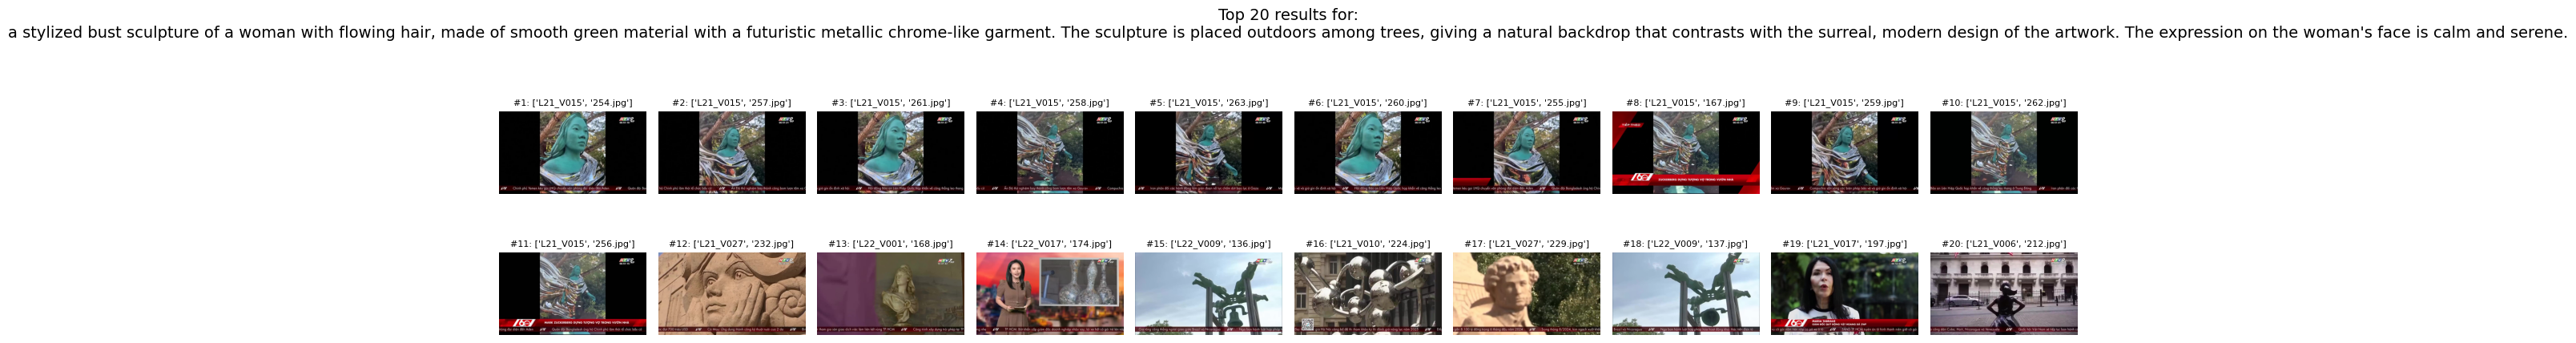

In [ ]:
# Encode query
query_vector = encode_text(query)
D, I = index.search(query_vector, k=TOPK)
print("Done searching !")
plt.figure(figsize=(20, 10))

# plot kết quả
plt.suptitle(f"Top {TOPK} results for:\n{query}", fontsize=14)
for idx, faiss_idx in enumerate(I[0]):
    img_path = faiss_id_to_image_path[faiss_idx]
    img_info = img_path.split("/")[7::]
    # print(img_info)
    try:
        img = Image.open(img_path)
        plt.subplot(5, 10, idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"#{idx + 1}: {img_info}", fontsize=8)
    except Exception as e:
        print(f"⚠️ Could not load {img_path}: {e}")

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# Temporal Search

In [ ]:
OUT_INDEX = "/content/drive/Shareddrives/data/features-longclip/faiss_longclip.bin"
OUT_META  = "/content/drive/Shareddrives/data/features-longclip/faiss_longclip.meta.jsonl"
KEYFRAME_ROOT = "/content/drive/Shareddrives/keyframe_btc"
CHECKPOINT_PATH = "/content/Long-CLIP/checkpoints/longclip-B.pt"

from model import longclip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = longclip.load(CHECKPOINT_PATH, device=device)

In [ ]:
# Load FAISS Index
index = faiss.read_index(OUT_INDEX)
print(f"✅ Loaded FAISS index with {index.ntotal} vectors")

✅ Loaded FAISS index with 16946 vectors


In [ ]:
# Load metadata từ JSONL
metadata = []
with open(OUT_META, "r") as f:
    for line in f:
        metadata.append(json.loads(line))

# Tạo list ánh xạ FAISS ID → ảnh keyframe
faiss_id_to_image_path = []
for entry in metadata:
    video_id = entry["filename"].replace(".npy", "")
    folder = entry["folder"]
    num_vectors = entry["num_vectors"]

    for i in range(1, num_vectors + 1):
        img_name = f"{i:03d}.jpg"
        img_path = os.path.join(KEYFRAME_ROOT, folder, "keyframes", video_id, img_name)
        faiss_id_to_image_path.append(img_path)

assert len(faiss_id_to_image_path) == index.ntotal, "Metadata không khớp với FAISS index!"

In [ ]:
def encode_text(text):
    tokens = longclip.tokenize([text]).to(device)
    with torch.no_grad():
        text_feat = model.encode_text(tokens)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    return text_feat.cpu().numpy().astype("float32")

In [ ]:
import torch.nn.functional as F

def from_numpy(tensor):
    return torch.from_numpy(tensor).to(device)

def temporal_search(queries, topk=1000, k_return=20):
    with torch.no_grad():
        assert len(queries) >= 1 and queries[0].strip() != ""

        text_features = [encode_text(q) for q in queries]
        D1, I1 = index.search(text_features[0], k=topk)

        video_set = set()
        for faiss_idx in I1[0]:
            for entry in metadata:
                num_vectors = entry["num_vectors"]
                if faiss_idx < num_vectors:
                    video_set.add(entry["path"])
                    break
                else:
                    faiss_idx -= num_vectors

        video_features = []
        video_names = []
        for path in video_set:
            if not os.path.exists(path):
                print(f"[WARN] Not found: {path}")
                continue
            feats = np.load(path).astype("float32")
            video_features.append(from_numpy(feats))
            video_names.append(Path(path).stem)

        if not video_features:
            print("⚠️ Không có file features nào được load.")
            return []

        text_features = [torch.from_numpy(f).to(device) for f in text_features]
        text_features = [F.normalize(f, dim=-1) for f in text_features]

        zero = torch.zeros(1).to(device)
        max_len = max(f.shape[0] for f in video_features)
        mask_full = torch.triu(torch.ones((max_len, max_len)).to(device))

        results = []
        for i, video_feat in enumerate(video_features):
            video_feat = F.normalize(video_feat, dim=-1)
            sims = [
                F.cosine_similarity(tf.expand(video_feat.shape[0], -1), video_feat) * 0.5 + 0.5
                for tf in text_features
            ]

            count = len(sims)
            score = sims[-1]
            mask = mask_full[1:video_feat.shape[0], 1:video_feat.shape[0]]

            # DP tracking
            dp = [sims[-1]]
            backtrack = []

            for j in range(count - 1, 0, -1):
                score_mat = dp[-1][1:].view(1, -1).expand(video_feat.shape[0] - 1, -1)
                masked = (mask * score_mat)
                best_next = masked.max(1)
                prev_score = torch.cat([best_next[0], zero]) + sims[j - 1]
                dp.append(prev_score)
                backtrack.append(best_next[1])  # indices

            dp = dp[::-1]
            backtrack = backtrack[::-1]
            final_score = dp[0] * 100.0 / count
            vals, idxs = torch.topk(final_score, k=min(k_return, final_score.shape[0]))

            for val, start_idx in zip(vals.tolist(), idxs.tolist()):
                chain = [start_idx]
                current = start_idx
                for j in range(len(backtrack)):
                    if current >= len(backtrack[j]):
                        break
                    current = backtrack[j][current].item() + 1
                    chain.append(current)

                if len(chain) == len(queries):
                    results.append({
                        "video": video_names[i],
                        "frames": chain,
                        "score": float(val)
                    })

        results.sort(key=lambda x: x["score"], reverse=True)
        print(results)
        return results[:k_return]


def plot_query_match(results, queries, num_pairs=10, image_size=(160, 90)):
    num_queries = len(queries)
    assert num_queries == 2, "Hiện tại chỉ hỗ trợ đúng 2 query cho 1 cặp ảnh"

    pairs_to_show = results[:num_pairs]
    total_images = len(pairs_to_show) * num_queries
    images_per_row = 10  # 5 cặp mỗi hàng
    rows = math.ceil(total_images / images_per_row)

    fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 2, rows * 2))

    if rows == 1:
        axes = [axes]  # make it 2D
    axes = np.array(axes).reshape(rows, images_per_row)

    for idx, res in enumerate(pairs_to_show):
        video = res["video"]
        frames = res["frames"]
        for q in range(num_queries):
            frame = frames[q]
            img_name = f"{frame:03d}.jpg"
            ax_idx = idx * num_queries + q
            row = ax_idx // images_per_row
            col = ax_idx % images_per_row
            ax = axes[row][col]

            found_path = None
            for entry in metadata:
                if entry["filename"].replace(".npy", "") == video:
                    folder = entry["folder"]
                    path = os.path.join(KEYFRAME_ROOT, folder, "keyframes", video, img_name)
                    if os.path.exists(path):
                        found_path = path
                    break

            if found_path and os.path.exists(found_path):
                img = Image.open(found_path).convert("RGB")
                img = img.resize(image_size)
                ax.imshow(img)
                filename_display = f"{video}/{img_name}"
                ax.set_title(f"{video} - Q{q+1}", fontsize=7)
                ax.set_xlabel(filename_display, fontsize=6)
                ax.tick_params(labelbottom=False, bottom=False, left=False, labelleft=False)
            else:
                ax.text(0.5, 0.5, "Not found", ha="center", va="center", fontsize=6)
                ax.axis("off")

    # turn off any unused axes
    for r in range(rows):
        for c in range(images_per_row):
            ax_idx = r * images_per_row + c
            if ax_idx >= total_images:
                axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
queries = ["A man and a woman are inside a modern boat's cabin, navigating and monitoring the sea using a digital nautical chart.",
           "a scuba diver underwater, inspecting coral or marine rocks with a flashlight and camera, conducting marine research or exploration."]

# queries = ["A traditional Bavarian band performs live indoors, with musicians wearing lederhosen and alpine hats while playing brass instruments and accordions.",
#            "The scene transitions to a cheerful group of people at a beer festival, smiling and posing with large decorated beer steins, celebrating in a cozy, wooden-decor-themed venue."]

results = temporal_search(queries, topk=50, k_return=50)
plot_query_match(results, queries, num_pairs=50)

Output hidden; open in https://colab.research.google.com to view.